## Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/GSelvakumar/storage/main/Helpers/helper_functions.py

--2022-10-01 14:46:12--  https://raw.githubusercontent.com/GSelvakumar/storage/main/Helpers/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10709 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.46K  --.-KB/s    in 0s      

2022-10-01 14:46:12 (64.7 MB/s) - ‘helper_functions.py’ saved [10709/10709]



In [ ]:
from helper_functions import unzip_data, plot_loss_curves, create_tensorboard_callback, compare_historys

In [ ]:
unzip_data("nlp_getting_started.zip")

## Visualizing the Text Dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv("nlp_getting_started/train.csv")
test_df = pd.read_csv("nlp_getting_started/test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# getting one data sample
train_df["text"][6845]

'in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3'

In [ ]:
# Shuffling the data so that the supervised model won't learn any patterns to follow the prediction
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# Number of examples on the target class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Visualize the random samples
import random
random_index = random.randint(0, len(train_df)-5) # less the length so the rand won't exceed it
for value in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  # itertuples are used to iterate over the dataframe rows and return them as tuples.
  _, text, target = value
  print(f"Target Value: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text Value:\n{text}\n")
  print("---\n")

Target Value: 0 (not real disaster)
Text Value:
Currently Blasting #Benediction - #SanelessTheory -on Metal Devastation Radio-  http://t.co/siGeeQ42cZ

---

Target Value: 0 (not real disaster)
Text Value:
sleeping with sirens vai vir pra sp

---

Target Value: 1 (real disaster)
Text Value:
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/6AcSWzo7cw

---

Target Value: 0 (not real disaster)
Text Value:
*Jumps off of a cliff while drinking tea*

This is how British people fall off cliffs.

---

Target Value: 1 (real disaster)
Text Value:
The Latest: More homes razed by Northern California wildfire - http://t.co/3tnuACIV3c http://t.co/SAkORGdqUL

---



## Spliting Data into Train and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                              train_df_shuffled['target'].to_numpy(),
                                                                              test_size=0.1, # 10% of the train data to be test data
                                                                              random_state=42)

In [ ]:
len(train_sentences), len(test_sentences), len(train_labels), len(test_labels)

(6851, 762, 6851, 762)

## Converting Text into Numbers

Before building the model need to convert the text into numbers using:

1. Tokenization - directly map a token to a number
2. Embedding - create a matrix of feature vector for each token(the size of the feature vector can be defined and this embedding can be learned)

### Text Vectorization - Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <oov>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    #pad_to_max_tokens=True # pad the feature axis which are less the max token axis, can be used only when max_tokens is mentioned
)

In [ ]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]))

102087

In [ ]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [ ]:
# Setup Text Vectorization Variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length the sequences will be (e.g. how many words from a tweet does a model see?)

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# fit the text vectorizer to the training text
"""
Computes a vocabulary of string terms from tokens in a dataset. Calling adapt() on 
Text Vectorization layer is an alternative to passing in a precomputed vocabulary
on construction via the vocabulary argument. A Text Vectorization layer should 
should always be either adapted over a dataset or supplied with a vocabulary.
"""
text_vectorizer.adapt(train_sentences)

In [ ]:
# Sample a sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
vectorize_sentence = text_vectorizer([random_sentence])
print(f"Original Text: \n {random_sentence} \n\n Vectorized Text: \n {vectorize_sentence}")

Original Text: 
 .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4 

 Vectorized Text: 
 [[1065 2675    9    3 2279   10 1848  313 2933 1280  463   57  650 1213
  3770]]


In [ ]:
# Get Unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words from the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words

In [ ]:
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding Using the Embedding Layer

Turns positive integers into dense vectors of fixed size

* `input_dim` - the size of the vocabulary
* `output_dim` - the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` - length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer='uniform',
                             input_length=max_length # how long is each input
                             )

embedding

In [ ]:
# Get a Random sentence from the training set
random_sentence = random.choice(train_sentences)

print(f"Original Text:\n {random_sentence} \n\nEmbedded Version: ")

# Embed the random sentence (turn positive integers into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 Good that the police are taking care of this and also have extra security  #HarryBeCareful 

Embedded Version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01984644,  0.00830482, -0.02854255, ...,  0.00801365,
          0.00329381,  0.01413194],
        [ 0.0418509 , -0.02610016,  0.02704556, ...,  0.01317421,
          0.04718161,  0.02245113],
        [-0.03159954, -0.03566319,  0.0407845 , ..., -0.03489129,
          0.03081178,  0.04574866],
        ...,
        [ 0.00588577,  0.02289568, -0.02169272, ...,  0.01465872,
          0.01658883,  0.04245586],
        [ 0.04143627, -0.03601048,  0.04565748, ...,  0.04255717,
         -0.03632572, -0.02699059],
        [ 0.04307368,  0.00493417,  0.02824464, ..., -0.00372275,
          0.0244881 , -0.0437237 ]]], dtype=float32)>

every single tweet are now in the form of 128 dense vectors. Always using the size as a divisible of 8 will increase the computation speed.

In [ ]:
# Checking out single token embedding
random_sentence, sample_embed[0][0], sample_embed[0][0].shape

('Good that the police are taking care of this and also have extra security  #HarryBeCareful',
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01984644,  0.00830482, -0.02854255, -0.0131613 ,  0.00325706,
        -0.01029898, -0.01251417, -0.04096501, -0.01988413,  0.00140612,
         0.0059981 ,  0.00981564,  0.00678983, -0.00233815,  0.00563979,
        -0.03230121, -0.0147931 ,  0.00925279,  0.04607068, -0.01691993,
        -0.01027177,  0.0496566 , -0.01788194,  0.04786152, -0.04479539,
        -0.03010346,  0.01114365,  0.01989922, -0.03875159,  0.02081323,
        -0.03444161,  0.01149971,  0.02774784, -0.00180935,  0.04884442,
         0.02733567,  0.03970024,  0.03066006,  0.03174544,  0.00719982,
        -0.00141595,  0.03227078, -0.0473914 , -0.04459813,  0.02357665,
         0.03320308, -0.01177299, -0.03823646,  0.00553447,  0.01544705,
         0.03169296, -0.0463669 ,  0.01536984, -0.04301878, -0.02385366,
        -0.02187085, -0.04730109, -0.03271252, -0.035

## Modelling a Text Dataset

- Model 0: Naive Bayes - sklearn(baseline)
- Model 1: Feed-Forward Neural Network(dense model)
- Model 2: LSTM Model (RNN)
- Model 3: GRU Model (RNN)
- Model 4: Bidirectional-LSTM Model (RNN)
- Model 5: 1D Conventional Neural Network (CNN)
- Model 6: Tensorflow Hub Pretrained Feature Extractor (using Transfer Learning for NLP)
- Model 7: Same as Model 6 with 10% of training data

## Model 0: Getting a Baseline Model

It's important to create a baseline model to attain a benchmark for future experiments/models to build upon. It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if it can be improved upon them.

Here the Baseline created is - SkLearn's Multinomial Naive Bayes using the TF-IDF formula to convert the words into numbers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Tokenization and Modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words into numbers using tfidf
    ("clf", MultinomialNB()) # model the text, clf-classification
])

# Fit the Pipeline to Training Data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the Baseline Model
baseline_score = model_0.score(test_sentences, test_labels)
print(f"The Baseline Model achieves an accuracy of: {baseline_score*100:.2f}%")

The Baseline Model achieves an accuracy of: 79.27%


In [ ]:
# make predictions
baseline_preds = model_0.predict(test_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary
  classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100

  # Calculate model precision, recall and f1-score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results={"accuracy": model_accuracy,
                 "precision": model_precision,
                 "recall": model_recall,
                 "f1": model_f1}

  return model_results

In [ ]:
# Get Baseline results
baseline_results = calculate_results(y_true=test_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A Simple Dense Model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Creating a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build Model with a Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create a embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so using sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20221001-144621
Epoch 1/5
215/215 [==============================] - 8s 9ms/step - loss: 0.6118 - accuracy: 0.6849 - val_loss: 0.5385 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4420 - accuracy: 0.8148 - val_loss: 0.4703 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3473 - accuracy: 0.8591 - val_loss: 0.4624 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2840 - accuracy: 0.8901 - val_loss: 0.4632 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2373 - accuracy: 0.9140 - val_loss: 0.4852 - val_accuracy: 0.7874


In [ ]:
# Check the results
model_1.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4852 - accuracy: 0.7874


[0.4852340519428253, 0.787401556968689]

In [ ]:
# make Predictions
model_1_pred_probs = model_1.predict(test_sentences)

In [ ]:
model_1_pred_probs.shape

(762, 1)

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1_pred_probs[0]

array([0.3209695], dtype=float32)

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [ ]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate the Model Results
model_1_results = calculate_results(y_true=test_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7932296029485675,
 'recall': 0.7874015748031497,
 'f1': 0.7841130596930417}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# check whether the baseline is out performing the first DEEP model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing Learned Embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 Summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer
"""
These are the numerical representations of each token in the training data, 
which have been learned for 5 epochs.
"""

embed_weights=model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape # same size as vocab size and embedding_dim (output_dim of the embedding layer)

(10000, 128)

Every token(10000) is embedded into a 128 shaped vector 

In [ ]:
# Create Embedding Files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue # skip 0, it's padding
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# # Download files from colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Network

RNN is useful for Sequence Data. The Premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

## Model 2: LSTM(Long Short Term Memory)

Structure of RNN

``` 
Input (Text) => Tokenize => Embedding =>  Layers (RNN/Dense) => Output (Label Probability)
```

In [ ]:
# Create an LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Get Model_2 summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20221001-144641
Epoch 1/5
215/215 [==============================] - 6s 9ms/step - loss: 0.2286 - accuracy: 0.9206 - val_loss: 0.5425 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1562 - accuracy: 0.9423 - val_loss: 0.5995 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1270 - accuracy: 0.9502 - val_loss: 0.7013 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1062 - accuracy: 0.9600 - val_loss: 0.7790 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0868 - accuracy: 0.9670 - val_loss: 1.0326 - val_accuracy: 0.7743


In [ ]:
# Make predictions with LSTM Model
model_2_pred_probs = model_2.predict(test_sentences)
model_2_pred_probs[:10]

array([[2.1888032e-03],
       [6.0524374e-01],
       [9.9980730e-01],
       [2.2326315e-02],
       [4.7604076e-04],
       [9.9937612e-01],
       [8.5028791e-01],
       [9.9989057e-01],
       [9.9980205e-01],
       [4.0506905e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(test_labels, model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.7799224267091094,
 'recall': 0.7742782152230971,
 'f1': 0.7706229446239603}

## Model 3: GRU

Another popular and effective RNN component is the GRU(Gated Recurrent Unit). The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build RNN using the GRU Cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.GRU(64, return_sequences=True)(x) # if the recurrent layers stacked, then the return_sequences must be True, the 64 refers the hidden layers.
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

without the global average pooling 1D layer the output returns the predictions for every token, but what need is the prediction of each sequence of data.

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20221001-144654
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1614 - accuracy: 0.9378 - val_loss: 0.7339 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0799 - accuracy: 0.9688 - val_loss: 0.8325 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0682 - accuracy: 0.9733 - val_loss: 1.1380 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0578 - accuracy: 0.9759 - val_loss: 1.1193 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0488 - accuracy: 0.9785 - val_loss: 1.1913 - val_accuracy: 0.7730


In [ ]:
# Prediction with GRU Model
model_3_pred_probs = model_3.predict(test_sentences)
model_3_pred_probs[:10]

array([[3.1173374e-03],
       [7.4438709e-01],
       [9.9987614e-01],
       [9.1521583e-02],
       [1.1745404e-04],
       [9.9978775e-01],
       [9.7995752e-01],
       [9.9996018e-01],
       [9.9991822e-01],
       [5.0216836e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=test_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7740517401498704,
 'recall': 0.7729658792650919,
 'f1': 0.7712160418848196}

## Model 4: Bidirectional RNN

RNN usually travel from left to right, but Bidirectional RNN travels on Both sides

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x) # bidirectional so 64 + 64 = 128
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,3

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20221001-144704
Epoch 1/5
215/215 [==============================] - 6s 11ms/step - loss: 0.1211 - accuracy: 0.9568 - val_loss: 0.8303 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0589 - accuracy: 0.9762 - val_loss: 1.0657 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0499 - accuracy: 0.9769 - val_loss: 1.0906 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0445 - accuracy: 0.9796 - val_loss: 1.3066 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0432 - accuracy: 0.9801 - val_loss: 1.3673 - val_accuracy: 0.7730


In [ ]:
# Make predictions with bidirectional model
model_4_pred_probs = model_4.predict(test_sentences)
model_4_pred_probs[:10]

array([[4.9363112e-04],
       [6.5757275e-01],
       [9.9988055e-01],
       [2.3434408e-01],
       [2.2506198e-05],
       [9.9990547e-01],
       [9.5602793e-01],
       [9.9998486e-01],
       [9.9993181e-01],
       [9.9881601e-01]], dtype=float32)

In [ ]:
# Convert probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of the bidirectional model
model_4_results = calculate_results(y_true=test_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.29658792650919,
 'precision': 0.77365375135567,
 'recall': 0.7729658792650919,
 'f1': 0.77144803030122}

## Convolutional Neural Network for Text (and other types of sequences)

The Typical structure of a **Conv1D** for sequences(text)

```
Inputs(Text) => Tokenization => Embedding => Layer(s) (typically Conv1D + Pooling) => Outputs (class probabilities)
```

### Model 5: Conv1D

In [ ]:
# Testing the embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is ngram of 5 means looks 5 words at a time
                        activation="relu",
                        padding="same") # default is valid, the output is smaller than the input shape, same means the output is same as input shape.
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the features with the highest value

In [ ]:
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [ ]:
# Create 1-dimensional Convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the Model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Model summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20221001-144723
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1228 - accuracy: 0.9587 - val_loss: 0.8996 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0737 - accuracy: 0.9736 - val_loss: 1.0327 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0607 - accuracy: 0.9755 - val_loss: 1.1426 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0541 - accuracy: 0.9780 - val_loss: 1.1775 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0503 - accuracy: 0.9801 - val_loss: 1.2310 - val_accuracy: 0.7638


In [ ]:
# make predictions 
model_5_pred_probs = model_5.predict(test_sentences)
model_5_pred_probs[:10]

array([[3.2880846e-02],
       [8.8012457e-01],
       [9.9996030e-01],
       [4.2408999e-02],
       [7.5127036e-07],
       [9.9764627e-01],
       [9.4113952e-01],
       [9.9999654e-01],
       [9.9999964e-01],
       [8.0233634e-01]], dtype=float32)

In [ ]:
# Convert model_5_pred_probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate Model 5 Predictions
model_5_results = calculate_results(y_true=test_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.37795275590551,
 'precision': 0.7647678424871814,
 'recall': 0.7637795275590551,
 'f1': 0.761896339990086}

## Model 6: Tensorflow Hub Pretrained Sentence Encoder

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you can the universal sentence encoder on a sentence, it turns into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In The USE (Universal Sentence Encoder) whatever the input is it will return 512 outputs.

In [ ]:
# Create a keras layer using the USE Pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create Model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of the USE pretrained embedding
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(test_sentences, test_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221001-144754
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5028 - accuracy: 0.7865 - val_loss: 0.4464 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4143 - accuracy: 0.8155 - val_loss: 0.4420 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4020 - accuracy: 0.8209 - val_loss: 0.4337 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3938 - accuracy: 0.8257 - val_loss: 0.4335 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3875 - accuracy: 0.8292 - val_loss: 0.4274 - val_accuracy: 0.8176


In [ ]:
# make predictions
model_6_pred_probs = model_6.predict(test_sentences)
model_6_pred_probs[:10]

array([[0.17687963],
       [0.78243446],
       [0.9885632 ],
       [0.18210103],
       [0.7412013 ],
       [0.7048023 ],
       [0.9802706 ],
       [0.9793012 ],
       [0.94333357],
       [0.09389146]], dtype=float32)

In [ ]:
# squeeze to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate Model 6 peformance metrics
model_6_results = calculate_results(y_true=test_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8190970972170162,
 'recall': 0.8175853018372703,
 'f1': 0.816365758450113}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% Training Data

making data splits like this leads to data leakage. This data splits leak data from validation/test to training data set.

In [ ]:
# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)

In [ ]:
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()

In [ ]:
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Build a model same as model_6 : Just cloning the layers not the weights
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent")]
                              )

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20221001-144812
Epoch 1/5
22/22 [==============================] - 2s 42ms/step - loss: 0.6745 - accuracy: 0.6161 - val_loss: 0.6586 - val_accuracy: 0.6509
Epoch 2/5
22/22 [==============================] - 0s 22ms/step - loss: 0.6102 - accuracy: 0.7854 - val_loss: 0.6040 - val_accuracy: 0.7572
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5370 - accuracy: 0.8204 - val_loss: 0.5453 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4727 - accuracy: 0.8219 - val_loss: 0.5091 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4268 - accuracy: 0.8365 - val_loss: 0.4923 - val_accuracy: 0.7808


In [ ]:
# make predictions
model_7_pred_probs = model_7.predict(test_sentences)
model_7_pred_probs[:10]

array([[0.22676557],
       [0.58281285],
       [0.90893376],
       [0.38268232],
       [0.54316425],
       [0.68539625],
       [0.876606  ],
       [0.8053596 ],
       [0.84605384],
       [0.1584504 ]], dtype=float32)

In [ ]:
# turn probs to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 results
model_7_results = calculate_results(y_true=test_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7818764826324955,
 'recall': 0.7808398950131233,
 'f1': 0.7792643495521726}

## Comparing the performance of each of the models

In [ ]:
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.740157,0.793230,0.787402,0.784113
2_lstm,77.427822,0.779922,0.774278,0.770623
3_gru,77.296588,0.774052,0.772966,0.771216
4_bidirectional,77.296588,0.773654,0.772966,0.771448
5_conv1d,76.377953,0.764768,0.763780,0.761896
6_tf_hub_use_encoder,81.758530,0.819097,0.817585,0.816366
7_tf_hub_use_encoder_10_percent,78.083990,0.781876,0.780840,0.779264


In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.793230,0.787402,0.784113
2_lstm,0.774278,0.779922,0.774278,0.770623
3_gru,0.772966,0.774052,0.772966,0.771216
4_bidirectional,0.772966,0.773654,0.772966,0.771448
5_conv1d,0.763780,0.764768,0.763780,0.761896
6_tf_hub_use_encoder,0.817585,0.819097,0.817585,0.816366
7_tf_hub_use_encoder_10_percent,0.780840,0.781876,0.780840,0.779264


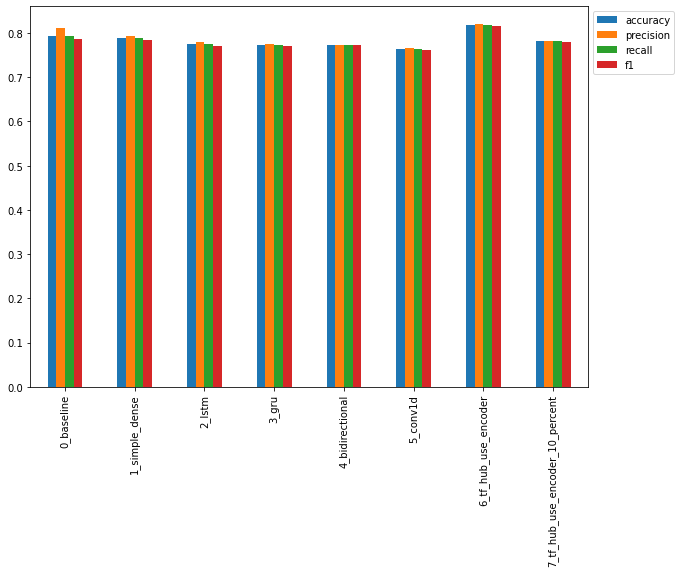

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

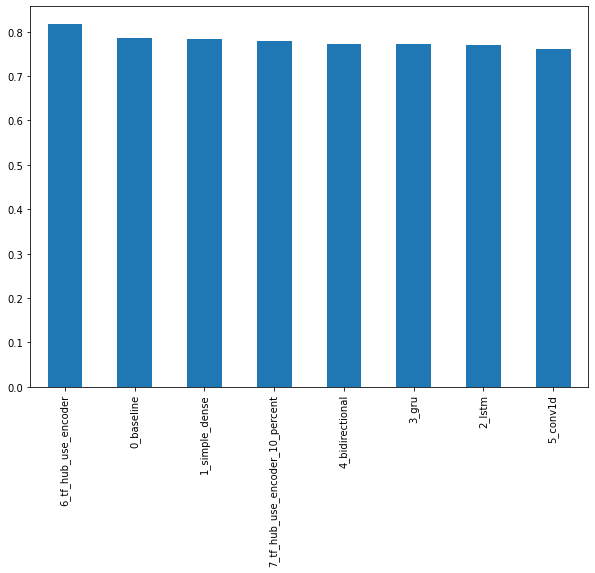

In [ ]:
# sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

## Tensorboard Logs

In [ ]:
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments" \
#   --description "Comparing multiple different types of model architecture on the Kaggle Tweets text classification dataset" \
#   --one_shot

https://tensorboard.dev/experiment/HMB5GQ5MSKeS0nw6ZSoGsw/#scalars - tensorboard link

In [ ]:
# See Previous experiments
# !tensorboard dev list

In [ ]:
#!tensorboard dev delete --experiment_id <experiment_id>

## Saving and Loading the Best performing Model

Two formats to save the model in tensorflow

1. The HDF5 Model
2. The SavedModel Format

In [ ]:
model_6.save("model_6.h5")

In [ ]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4274 - accuracy: 0.8176


[0.4274255037307739, 0.817585289478302]

In [ ]:
model_6.save("model_6_SavedModel_format")

In [ ]:
loaded_model_model_6_savedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_model_6_savedModel_format.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4274 - accuracy: 0.8176


[0.4274255037307739, 0.817585289478302]

## Finding the Most Wrong Predictions

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-10-01 14:48:43--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  49.5MB/s    in 21s     

2022-10-01 14:49:04 (44.0 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [ ]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
model_6_pretrained.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make Predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(test_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
val_df = pd.DataFrame({"text": test_sentences,
                       "target": test_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
most_wrong = val_df[val_df['pred'] != val_df['target']].sort_values("pred_prob", ascending=False)
most_wrong.head() # False Positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [ ]:
most_wrong.tail() # False negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Check the False positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1.0, Prob: 0.8148158192634583
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Tar

In [ ]:
# Check the False positives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

---

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

---

Target: 1, Pred: 0.0, Prob: 0.042086

## Making Predictions on a Test Dataset

In [ ]:
# make predictions on test data and visualize them
test_sentences = test_df['text'].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [ ]:
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))# model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("------\n")

Pred: 1, Prob: 0.9500387907028198
Text:
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/xJm6Snk1G0

------

Pred: 0, Prob: 0.42041850090026855
Text:
Finnish Nuclear Plant to Move Ahead After Financing Secured http://t.co/S9Jhcf3lD7 @JukkaOksaharju @ollirehn @juhasipila

------

Pred: 0, Prob: 0.09595008194446564
Text:
WHAT AN INCREDIBLE CHARACTER MY HEART IS BROKEN THAT HE IS ACTUALLY DEAD!! #RIPROSS WE WILL MISS YOU!  https://t.co/LgqmdnaVDf

------

Pred: 0, Prob: 0.017011698335409164
Text:
Just want someone to smoke a blunt &amp; talk about life with ??

------

Pred: 1, Prob: 0.9833021759986877
Text:
Sinjar Massacre Yazidis Blast Lack of Action Over Hostages http://t.co/fdU8aCnC2W #denver #billings #rapidcity #seattle #cheyenne #lasvegas

------

Pred: 1, Prob: 0.9168365597724915
Text:
Train derailed at Smithsonian Metro. Sidewalks outside L'Enfant mobbed to get on buses @wmata #nightmarecommute

------



## The Speed/Score Tradeoff

In [ ]:
# Function to measure the time taken for prediction
import time

def pred_timer(model, samples):
  """
  Time how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [ ]:
# calculate TF hub sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=test_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.9216799079999873, 0.00028246396199815734)

In [ ]:
# Calculate the Baseline Model time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, test_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.1033885920001012, 3.168513392586614e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true=test_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results 

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

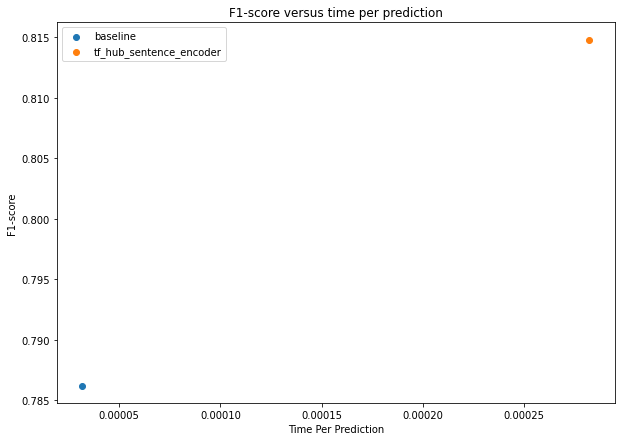

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time Per Prediction")
plt.ylabel("F1-score");